# GUC Classification Model using logistic regression

### Import packages and data set
#### Import the "Payment data" file 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [38]:
# df=pd.read_csv("Online_Payments_1000_rows.csv")
df=pd.read_csv("PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


> since the 'nameOrig' and 'nameDest' are not affecting the decision, we wouldn't take them in accounting

### categorical features Encoding

In [42]:
print(df['type'].unique())
print(df['type'].nunique())

['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
5


In [43]:
df["type"]= df.type.replace({"PAYMENT": 1, "TRANSFER": 2, "CASH_OUT": 3, "DEBIT": 4, "CASH_IN": 5})

In [8]:
# df["nameOrig"] = df["nameOrig"].apply(lambda x : x[1:]).astype(str).astype(int)

In [9]:
# df["nameOrig"]

### Scale the features using sklearn.preprocessing package

In [44]:
# the scaler - for standard scaler of Normalization
from sklearn.preprocessing import StandardScaler

# set up the scaler
scaler = StandardScaler()

**Fit the features data only to this estimator (leaving the TARGET CLASS column) and transform**

In [45]:
scaler.fit(df.drop(['nameOrig','nameDest','isFraud','isFlaggedFraud'],axis=1))
scaled_features = scaler.transform(df.drop(['nameOrig','nameDest','isFraud','isFlaggedFraud'],axis=1))

In [46]:
df_feat = pd.DataFrame(scaled_features,columns=["step", "type", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"])
df_feat.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,-1.703042,-1.130722,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411
1,-1.703042,-1.130722,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411
2,-1.703042,-0.460191,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411
3,-1.703042,0.210340,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411
4,-1.703042,-1.130722,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411


In [47]:
df_feat.shape

(6362620, 7)

### Input and Output

In [48]:
# input
X = df.iloc[:, [0,1,2,4,5,7,8]].values
#X = df_feat.values

# output
y = df.iloc[:, 9].values


In [10]:
# print(f'{X[0]} \n {type(X[1])}')

### Train/CV/Test split, model fit and prediction

In [49]:

# split the full data 80:20 into training:validation sets
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=0)

# split training data 87.5:12.5 into training:testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.775, random_state=0)

print("len(X): {} len(y): {} \nlen(X_train): {}, len(X_valid): {}, len(X_test): \
{} \nlen(y_train): {}, len(y_valid): {}, len(y_test): {}".format(len(X), len(y),\
len(X_train), len(X_valid), len(X_test), len(y_train), len(y_valid), \
len(y_test))) 

len(X): 6362620 len(y): 6362620 
len(X_train): 3451721, len(X_valid): 1908786, len(X_test): 1002113 
len(y_train): 3451721, len(y_valid): 1908786, len(y_test): 1002113


In [ ]:
# # the scaler - for standard scaler of Normalization
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_valid)
# X_test = scaler.transform(X_test)

### Logistic regression

* Train Data is used in selecting parameters
<br>
* CV Data is used in selecting the order of the polynomial
<br>
* Test Data to see how this polynomial generalizes will in further test examples

[Reference](https://www.kaggle.com/code/tijelm/online-payment-fraud-detection-eda-classification)

#### 1. select the degree, train the model on the degree, then evaluate on the CV

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [51]:
CVdegree = []
CVacc = []
CVcost = []

#thetas = []

Traindegree = []
Trainacc = []
Traincost = []
def hypothesis_degree(n):
    for i in range(n):
        #select the degree & transform the X to the higher degree
        poly = PolynomialFeatures(degree = i+1, interaction_only=False, include_bias=False)
        X_poly = poly.fit_transform(X_train)

        #train the model on the new degree
        lr = LogisticRegression(random_state = 0)
        lr.fit(X_poly,y_train)

        #evaluate the degree selection on a new data which is the CV using the Jcv cost function
        from sklearn.metrics import accuracy_score
        y_predT = lr.predict(X_poly)
        sT= accuracy_score(y_train, y_predT)
        len = y_train.shape[0]
        cT=(1/(2*len))*np.sum((y_predT-y_train)**2)
        #(-1/(len))*np.sum(y_valid*np.log(y_pred)+(1-y_valid)*np.log(1-y_pred))
        Traindegree.append(i+1)
        Trainacc.append(sT)
        Traincost.append(cT)
        
        #evaluate the degree selection on a new data which is the CV using the Jcv cost function
        from sklearn.metrics import accuracy_score
        y_pred = lr.predict(poly.transform(X_valid))
        s= accuracy_score(y_valid, y_pred)
        len = y_valid.shape[0]
        c=(1/(2*len))*np.sum((y_pred-y_valid)**2)
        CVdegree.append(i+1)
        CVacc.append(s)
        CVcost.append(c)
        
#         #the thetas' values for each hypothesis degree
#         for idcoff, columnname in enumerate(df.iloc[:, [0,1,2,4,5,7,8]].columns):
#             thetas.append("The coefficient for {} is {}".format(columnname, lr.coef_[0][idcoff]))
#         thetas.append("============================================ ")
            
            
            
#         print("\n ============================================ \n")

In [52]:
hypothesis_degree(4)

C:\Users\abdog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\abdog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [53]:
print(f'cost function values = {CVcost} \n accuracy values = {CVacc} \n Hypothesis Degree = {CVdegree}')
#print(f'cost function values = {CVcost} \n accuracy values = {CVacc} \n Hypothesis Degree = {CVdegree}  \n Thetas Values = {thetas}')
print(f'\n ============================================ \n')
print(f'cost function values = {Traincost} \n accuracy values = {Trainacc} \n Hypothesis Degree = {Traindegree}')

cost function values = [0.0008691388138848461, 0.0006336488218165892, 0.0006336488218165892, 0.0006336488218165892] 
 accuracy values = [0.9982617223722303, 0.9987327023563668, 0.9987327023563668, 0.9987327023563668] 
 Hypothesis Degree = [1, 2, 3, 4]


cost function values = [0.0008371186431348304, 0.0006530075866502536, 0.0006530075866502536, 0.0006530075866502536] 
 accuracy values = [0.9983257627137303, 0.9986939848266995, 0.9986939848266995, 0.9986939848266995] 
 Hypothesis Degree = [1, 2, 3, 4]


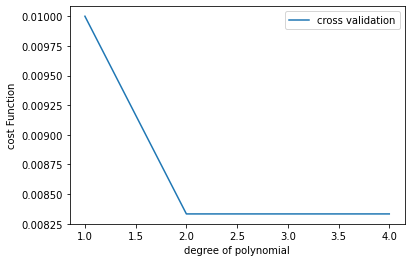

In [22]:
# plt.figure()
# plt.plot(CVdegree, CVcost)
# plt.ylabel(f'cost Function')
# plt.xlabel('degree of polynomial')
# plt.legend(['cross validation'],loc='upper right')

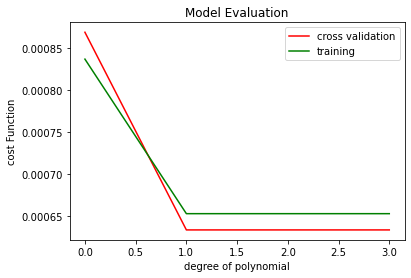

In [55]:
plt.figure()
plt.title("Model Evaluation")
plt.plot(CVcost,'r')
plt.plot(Traincost,'g')
plt.ylabel(f'cost Function')
plt.xlabel('degree of polynomial')
plt.legend(['cross validation','training'],loc='upper right')

* Observation:-
>the best and simple degree is one

In [56]:
#select the degree & transform the X to the higher degree
poly = PolynomialFeatures(degree = 1, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_train)

In [57]:
#train the model on the new degree
lr = LogisticRegression(random_state = 0)
lr.fit(X_poly,y_train)

LogisticRegression(random_state=0)

In [59]:
#another way for cal. the score
# check the score section in link (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
print(lr.score(poly.transform(X_valid), y_valid))

print("============================================")

y_pred = lr.predict(poly.transform(X_valid))
print(classification_report(y_valid, y_pred))

0.9982617223722303
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906367
           1       0.35      0.43      0.38      2419

    accuracy                           1.00   1908786
   macro avg       0.67      0.71      0.69   1908786
weighted avg       1.00      1.00      1.00   1908786



* **_Precision:_** Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In your prediction case, when your Logistic Regression model predicted patients are going to suffer from diabetes, that patients have 76% of the time.

* **_Recall:_** If there are patients who have diabetes in the test set and your Logistic Regression model can identify it 58% of the time.

In [60]:
#Return the coefficient of determination of the input features of the prediction
from sklearn.metrics import accuracy_score
y_pred = lr.predict(poly.transform(X_valid))
print ("Accuracy : ", accuracy_score(y_valid, y_pred))

Accuracy :  0.9982617223722303


In [61]:
#Evaluate the generalization by Jtest

#predict
y_predTest = lr.predict(poly.transform(X_test))

#cost Cal.
len = y_train.shape[0]
cTest=(1/(2*len))*np.sum((y_predTest-y_test)**2)

#print
print(f'Estimatation of generalization error for test set {cTest}')#Evaluate the generalization by Jtest

Estimatation of generalization error for test set 0.0002430671540370731


#### 2. calculate the theta's
> They have value with degree one only

> The sign of each coefficient indicates the direction of the relationship between a predictor variable and the response variable.

> The coefficient value represents the mean change in the response given a one unit change in the predictor. For example, if a coefficient is +3, the mean response value increases by 3 for every one unit change in the predictor.

[Reference](https://statisticsbyjim.com/glossary/regression-coefficient/#:~:text=Regression%20coefficients%20are%20estimates%20of,that%20multiply%20the%20predictor%20values.)

In [140]:
# df.iloc[:, [0,1,2,4,5,7,8]].columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest'],
      dtype='object')

In [15]:
# lr.coef_

array([[-6.78286224e-05, -7.60187827e-05, -9.36894403e-02,
         8.92542429e-02, -1.53439248e-01, -1.20767644e-01,
         2.36765066e-03]])

In [62]:
#the thetas' values
for idcoff, columnname in enumerate(df.iloc[:, [0,1,2,4,5,7,8]].columns):
    print("The coefficient for {} is {}".format(columnname, lr.coef_[0][idcoff]))

The coefficient for step is -0.02633297452128605
The coefficient for type is -0.00013241490394995674
The coefficient for amount is -0.00023434817894624365
The coefficient for oldbalanceOrg is 0.00025390059655869404
The coefficient for newbalanceOrig is -0.0002781642552211436
The coefficient for oldbalanceDest is 7.5767330754892094e-06
The coefficient for newbalanceDest is -8.702207824115345e-06


In [96]:
# #the thetas' values for the first 1000 rows
# for idcoff, columnname in enumerate(df.iloc[:, [0,1,2,4,5,7,8]].columns):
#     print("The coefficient for {} is {}".format(columnname, lr.coef_[0][idcoff]))

The coefficient for step is -6.782862238774632e-05
The coefficient for type is -7.601878269971139e-05
The coefficient for amount is -0.09368944033546621
The coefficient for oldbalanceOrg is 0.08925424289498013
The coefficient for newbalanceOrig is -0.15343924825806615
The coefficient for oldbalanceDest is -0.12076764350860318
The coefficient for newbalanceDest is 0.002367650655803926


#### 3. Testing based on the test set

In [63]:
#evaluate the degree selection on a new data which is the test set using the Jtest cost fucntion (score)
print(f'The score = {lr.score(poly.transform(X_test), y_test)*100} %')
print("============================================")
y_predtest = lr.predict(poly.transform(X_test))
print(classification_report(y_test, y_predtest))

The score = 99.83255381379146 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1000827
           1       0.37      0.43      0.40      1286

    accuracy                           1.00   1002113
   macro avg       0.68      0.72      0.70   1002113
weighted avg       1.00      1.00      1.00   1002113



* **_Precision:_** Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In your prediction case, when your Logistic Regression model predicted patients are going to suffer from diabetes, that patients have 76% of the time.

* **_Recall:_** If there are patients who have diabetes in the test set and your Logistic Regression model can identify it 58% of the time.

-------------------------------------------------------------------------------------------

### Regularization
> Now, will apply regularization techniques and review the scores and impact of the techniques on the model.
<br>
> Shrinkage method, which we use to add the penalty term to control the complex model to avoid overfitting by reducing the variance.

[Reference1](https://www.analyticsvidhya.com/blog/2021/11/study-of-regularization-techniques-of-linear-model-and-its-roles/)
<br>
[Reference2](https://harish-reddy.medium.com/regularization-in-python-699cfbad8622#:~:text=How%20does%20regularization%20work%3F,term%E2%80%9D%20that%20penalizes%20coefficient%20size.)

##### Ridge Regression Regularization (L2)

In [64]:
λ=[0.01,0.02,0.04,0.08,0.16,0.32,0.64,1.28,2.56,5.12,10.24] #values from page 10 Lecture Diagnostics II

In [65]:
#RIDGE (L2)		LASSO (L1)
from sklearn import linear_model
for i in λ:
    ridge = linear_model.Ridge(alpha=i)
    ridge.fit(X_poly,y_train)
    print ("Ridge model:", (ridge.coef_))
    print(f'For parameter equals {i} :-')
    print(ridge.score(poly.transform(X_train), y_train))
    print(ridge.score(poly.transform(X_test), y_test))
    print("\n ========================= \n")

Ridge model: [ 6.22905265e-06  3.36188145e-03  1.17116361e-08  1.08926245e-07
 -1.08487591e-07  8.35683195e-09 -8.61256694e-09]
For parameter equals 0.01 :-
0.17188596762210617
0.15945995791651713


Ridge model: [ 6.22905265e-06  3.36188144e-03  1.17116361e-08  1.08926245e-07
 -1.08487591e-07  8.35683195e-09 -8.61256694e-09]
For parameter equals 0.02 :-
0.1718859676221064
0.15945995791691614


Ridge model: [ 6.22905265e-06  3.36188143e-03  1.17116361e-08  1.08926245e-07
 -1.08487591e-07  8.35683196e-09 -8.61256695e-09]
For parameter equals 0.04 :-
0.17188596762210617
0.1594599579177144


Ridge model: [ 6.22905265e-06  3.36188141e-03  1.17116361e-08  1.08926245e-07
 -1.08487591e-07  8.35683197e-09 -8.61256696e-09]
For parameter equals 0.08 :-
0.17188596762210728
0.1594599579193139


Ridge model: [ 6.22905264e-06  3.36188136e-03  1.17116361e-08  1.08926245e-07
 -1.08487591e-07  8.35683199e-09 -8.61256698e-09]
For parameter equals 0.16 :-
0.17188596762210662
0.15945995792251


Ridge model

* The optimal value for λ is 1.28
>•Very small value of 𝜆 will cause over fitting in complicated Hypothesis
<br>
>•Very large value of 𝜆 will cause under fitting
<br>
 - since I want to minimize the cost function, so for this small lampda, the theta's will have big values meaning I included alot of features which may lead to overfitting

In [1]:
# #RIDGE (L2)		LASSO (L1)
# predict_val=[]
# predict_train=[]

# import sklearn.metrics as metrics
# from sklearn import linear_model
# for i in λ:
#     #ridge = linear_model.Ridge(alpha=i)
#     #lr_clf=LogisticRegression(penalty='l2', C=i, solver='liblinear')
#     ridge = linear_model.Ridge(alpha=i)
#     ridge.fit(X_poly,y_train)
#     print ("Ridge model:", (ridge.coef_))
#     print(f'For parameter equals {i} :-')
#     print(ridge.score(poly.transform(X_train), y_train))
#     print(ridge.score(poly.transform(X_test), y_test))
#     print("\n ========================= \n")
    
#     pred_val=ridge.predict(X_valid)
#     accuracy_val=metrics.explained_variance_score(y_valid,pred_val)
#     err_val=1-accuracy_val
#     predict_val.append(1-accuracy_val)
    
#     pred_train=ridge.predict(X_train)
#     accuracy_train=metrics.explained_variance_score(y_train,pred_train)
#     predict_train.append(1-accuracy_train)
    
# fig, ax = plt.subplots()
# ax.plot(λ, predict_train, '-b', label='Train')
# ax.plot(λ, predict_val, '-r', label='Cross_validation')
# plt.xlabel("lambda (Regularization)")
# plt.ylabel("Cost Function")
# leg = ax.legend(loc='upper right');

Ridge model: [[-2.47706057e-02 -6.00687435e-04 -2.40283226e-04  2.59329206e-04
  -2.83733649e-04  7.47972509e-06 -8.59874907e-06]]
For parameter equals 0.01 :-
0.998338220267513
0.9983365149439235


Ridge model: [[-2.58840674e-02 -9.13854456e-04 -2.35368379e-04  2.54767983e-04
  -2.79052638e-04  7.54310881e-06 -8.66547664e-06]]
For parameter equals 0.02 :-
0.9983330054775574
0.9983305275951914


Ridge model: [[-2.61952041e-02 -9.93621762e-04 -2.34757105e-04  2.54267786e-04
  -2.78526083e-04  7.56940208e-06 -8.69276972e-06]]
For parameter equals 0.04 :-
0.9983309775036858
0.998329529703736


Ridge model: [[-2.56868159e-02 -7.44667492e-04 -2.36682406e-04  2.56015772e-04
  -2.80337366e-04  7.52988349e-06 -8.65071912e-06]]
For parameter equals 0.08 :-
0.9983344540303228
0.9983285318122807


Ridge model: [[-2.57787369e-02 -8.10163955e-04 -2.36334053e-04  2.55702080e-04
  -2.80009136e-04  7.53868898e-06 -8.66012896e-06]]
For parameter equals 0.16 :-
0.9983332951881105
0.9983305275951914


Ri

C:\Users\abdog\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Ridge model: [[-1.27068333e-02 -1.03782559e-04 -3.54547678e-04  3.69489869e-04
  -4.00098265e-04  7.14186957e-06 -8.13682323e-06]]
For parameter equals 1.28 :-
0.9985427559179899
0.9985311037777177


Ridge model: [[-2.57086126e-02 -7.53831411e-04 -2.36599769e-04  2.55941340e-04
  -2.80259582e-04  7.53196731e-06 -8.65295839e-06]]
For parameter equals 2.56 :-
0.9983341643197697
0.998329529703736


Ridge model: [[-2.56987774e-02 -7.85611600e-04 -2.36634219e-04  2.55972238e-04
  -2.80291260e-04  7.53109733e-06 -8.65195516e-06]]
For parameter equals 5.12 :-
0.9983341643197697
0.998329529703736


Ridge model: [[-2.56782380e-02 -7.42971448e-04 -2.36714139e-04  2.56044278e-04
  -2.80367144e-04  7.52906305e-06 -8.64983494e-06]]
For parameter equals 10.24 :-
0.9983344540303228
0.9983285318122807




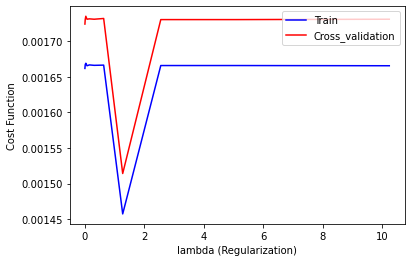

In [67]:
#RIDGE (L2)		LASSO (L1)
predict_val=[]
predict_train=[]

from sklearn import linear_model
for i in λ:
    #ridge = linear_model.Ridge(alpha=i)
    lr_clf=LogisticRegression(penalty='l2', C=i, solver='liblinear')
    lr_clf.fit(X_poly,y_train)
    print ("Ridge model:", (lr_clf.coef_))
    print(f'For parameter equals {i} :-')
    print(lr_clf.score(poly.transform(X_train), y_train))
    print(lr_clf.score(poly.transform(X_test), y_test))
    print("\n ========================= \n")
    
    pred_val=lr_clf.predict(X_valid)
    accuracy_val=accuracy_score(y_valid,pred_val)
    err_val=1-accuracy_val
    predict_val.append(1-accuracy_val)
    
    pred_train=lr_clf.predict(X_train)
    accuracy_train=accuracy_score(y_train,pred_train)
    predict_train.append(1-accuracy_train)
    
fig, ax = plt.subplots()
ax.plot(λ, predict_train, '-b', label='Train')
ax.plot(λ, predict_val, '-r', label='Cross_validation')
plt.xlabel("lambda (Regularization)")
plt.ylabel("Cost Function")
leg = ax.legend(loc='upper right');

* The optimal value for λ is 0.00; meaning Keep all Features without reducing any parameters
>•Very small value of 𝜆 will cause over fitting in complicated Hypothesis
<br>
>•Very large value of 𝜆 will cause under fitting

##### Lasso Regression Regularization (L1)

In [144]:
for i in λ: 
    lasso = linear_model.Lasso(alpha=i)
    lasso.fit(X_poly,y_train)
    print ("Lasso model:", (lasso.coef_))
    print(f'For parameter equals {i}:-')
    print(lasso.score(poly.transform(X_train), y_train))
    print(lasso.score(poly.transform(X_test), y_test))
    print("\n ========================= \n")

<ipython-input-144-227a33c6002e>:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_poly,y_train)
C:\Users\abdog\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\abdog\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2672349472721121, tolerance: 9.981515711645101e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\abdog\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.281405661635047, tolerance: 9.981515711645101e-05
  model = cd_fa

Lasso model: [ 0.00000000e+00  5.43880504e-03  3.86283141e-08  2.71779797e-07
 -2.68315228e-07  1.03384365e-09 -1.99952592e-09]
For parameter equals 0:-
0.4645403463918043
0.1915801453444831


Lasso model: [ 0.00000000e+00  0.00000000e+00  4.09520541e-08  2.60149816e-07
 -2.54689620e-07  1.65600979e-09 -1.97499644e-09]
For parameter equals 0.01:-
0.4361223549713421
0.18238835269914588


Lasso model: [ 0.00000000e+00  0.00000000e+00  4.09518640e-08  2.60147586e-07
 -2.54687437e-07  1.65596256e-09 -1.97497008e-09]
For parameter equals 0.02:-
0.43612135604544067
0.1823872187584391


Lasso model: [ 0.00000000e+00  0.00000000e+00  4.09514837e-08  2.60143128e-07
 -2.54683070e-07  1.65586811e-09 -1.97491735e-09]
For parameter equals 0.04:-
0.43611935806787805
0.18238495085307804


Lasso model: [ 0.00000000e+00  0.00000000e+00  4.09507231e-08  2.60134210e-07
 -2.54674337e-07  1.65567921e-09 -1.97481190e-09]
For parameter equals 0.08:-
0.43611536160965425
0.18238041494650314


Lasso model: [ 0.

C:\Users\abdog\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26993892216591625, tolerance: 9.981515711645101e-05
  model = cd_fast.enet_coordinate_descent(


* The optimal value for λ is 0.00; meaning Keep all Features without reducing any parameters
>•Very small value of 𝜆 will cause over fitting in complicated Hypothesis
<br>
>•Very large value of 𝜆 will cause under fitting

LASSO model: [[ 4.84424162e-03  5.20183204e-01 -1.40916769e-05  3.08991513e-05
  -3.53534295e-05  6.30739062e-06 -6.45150246e-06]]
For parameter equals 0.01 :-
0.9992736956434196
0.9992615603230374


LASSO model: [[ 5.12344374e-03  5.88279037e-01 -1.41667405e-05  3.11270596e-05
  -3.56108454e-05  6.38570719e-06 -6.53452612e-06]]
For parameter equals 0.02 :-
0.9992768824595035
0.9992635561059481


LASSO model: [[ 5.26681532e-03  6.23268770e-01 -1.41720612e-05  3.12141613e-05
  -3.57154281e-05  6.42330318e-06 -6.57444650e-06]]
For parameter equals 0.04 :-
0.9992765927489504
0.9992635561059481


LASSO model: [[ 5.33990494e-03  6.41084592e-01 -1.41733207e-05  3.12616223e-05
  -3.57725002e-05  6.44458712e-06 -6.59683084e-06]]
For parameter equals 0.08 :-
0.9992765927489504
0.9992635561059481


LASSO model: [[ 5.37671347e-03  6.49878957e-01 -1.41444846e-05  3.12523119e-05
  -3.57668822e-05  6.45171956e-06 -6.60454256e-06]]
For parameter equals 0.16 :-
0.9992771721700566
0.9992635561059481




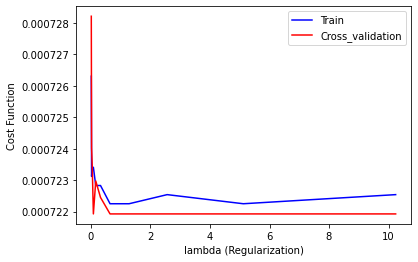

In [68]:
#RIDGE (L2)		LASSO (L1)
predict_val=[]
predict_train=[]

from sklearn import linear_model
for i in λ:
    lr_clf=LogisticRegression(penalty='l1', C=i, solver='liblinear')
    lr_clf.fit(X_poly,y_train)
    print ("LASSO model:", (lr_clf.coef_))
    print(f'For parameter equals {i} :-')
    print(lr_clf.score(poly.transform(X_train), y_train))
    print(lr_clf.score(poly.transform(X_test), y_test))
    print("\n ========================= \n")
    
    pred_val=lr_clf.predict(X_valid)
    accuracy_val=accuracy_score(y_valid,pred_val)
    err_val=1-accuracy_val
    predict_val.append(1-accuracy_val)
    
    pred_train=lr_clf.predict(X_train)
    accuracy_train=accuracy_score(y_train,pred_train)
    predict_train.append(1-accuracy_train)
    
fig, ax = plt.subplots()
ax.plot(λ, predict_train, '-b', label='Train')
ax.plot(λ, predict_val, '-r', label='Cross_validation')
plt.xlabel("lambda (Regularization)")
plt.ylabel("Cost Function")
leg = ax.legend(loc='upper right');

_Model fitment justification during training and testing_

* Model is doing strongly at training set and poorly in test set means we’re at OVERFIT
* Model is doing poor at both (Training and Testing) means we’re at UNDERFIT
* Model is doing better and considers ways in both (Training and Test), means we’re at the RIGHT FIT

-------------------------------------------------------------------------------------------

### K-fold and Stratified Sampling

* KFold is a cross-validator that divides the dataset into k folds and distribute those between the train & test sets.
<br>
* Stratified is to ensure that each fold of dataset has the same proportion of observations with a given label.

> #### 1. K-fold
[Reference1](https://oralytics.com/2020/09/21/k-fold-repeated-k-fold-cross-validation-in-python/)
<br>
[Reference2](https://medium.com/analytics-vidhya/cross-validation-in-machine-learning-using-python-4d0f335bec83)

* _The difference between KFold & RepeatedKFold_
 
 - The estimate of model performance via k-fold cross-validation can be noisy.

 - This means that each time the procedure is run, a different split of the dataset into k-folds can be implemented, and in turn, the distribution of performance scores can be different, resulting in a different mean estimate of model performance.

 - One solution to reduce the noise in the estimated model performance is to increase the k-value. This will reduce the bias in the model’s estimated performance, although it will increase the variance: e.g. tie the result more to the specific dataset used in the evaluation.

 - An alternate approach is to repeat the k-fold cross-validation process multiple times and report the mean performance across all folds and all repeats. This approach is generally referred to as repeated k-fold cross-validation.
<br>
[Reference](https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/)

* RepeatedKFold

In [156]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

# prepare the cross-validation procedure
CrossValidation = RepeatedKFold(n_splits=10, n_repeats= 100, random_state=1)

# getting misclassification rate
scores = 1 - cross_val_score(lr, X, y, scoring='accuracy', cv=CrossValidation, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.007 (0.009)


* KFold

In [158]:
#load scikit-learn k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#setup for k-Fold Cross Validation
cv = KFold(n_splits=20, shuffle=True, random_state=0)
#n_splits = number of k-folds
#shuffle = shuffles data set prior to split
#radnom_state = seed for (pseydo)random number generator

#define model
model = lr
#create model, perform cross validation and evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#performance result
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.994 (0.011)


In [ ]:
# print(f"Mean of misclassification error rate in test date is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
# #Note:- best split result with n_splits=20

# import seaborn as sns
# ax = sns.histplot(x=scores, kde=True)

* _Stratified K-Folds cross-validator_
 - Provides train/test indices to split data in train/test sets. This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

[Reference](https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/)

> #### Stratified Sampling Using Proportions
[Reference1](https://thecleverprogrammer.com/2020/12/22/stratified-sampling-with-python/)
<br>
[Reference2](https://www.statology.org/stratified-sampling-pandas/)
<br>
[Reference3](https://www.geeksforgeeks.org/stratified-sampling-in-pandas/)

The following code shows how to perform stratified random sampling such that the proportion of players in the sample from each team matches the proportion of players from each team in the larger DataFrame:

In [139]:
import numpy as np

#define total sample size desired
N = 4
#perform stratified random sampling
df.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)`

###########################
#perform stratified random sampling
# df.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(frac=0.01))

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,2618.76,C1068945248,21867.46,19248.70,M937277082,0.00,0.00,0,0
1,1,1,10497.33,C1717739363,2684.69,0.00,M138536309,0.00,0.00,0,0
2,1,1,1928.55,C1959451969,5096.00,3167.45,M777313177,0.00,0.00,0,0
3,1,3,92553.64,C1788380050,0.00,0.00,C1182461167,297655.51,23508.22,0,0


no results for 'isFraud' equal one since there are only 9 out of 1000 so the frac percentage couldn't inlcude them

-----------------------------------------------------------------------------------------------------

>#### 2. Stratified Sampling Using Counts

The following code shows how to perform stratified random sampling by randomly selecting 2 observations from each category of Fraud to be included in the sample:

In [132]:
df.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(2))

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
204,1,3,101940.14,C1393828949,0.0,0.00,C357863579,105362.0,92307.65,0,0
951,1,1,3464.41,C1245593227,5548.0,2083.59,M1525844775,0.0,0.00,0,0
680,1,2,20128.00,C137533655,20128.0,0.00,C1848415041,0.0,0.00,1,0
3,1,3,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.00,1,0


-------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------

# <center><font color = yellow> الحمد لله </font> <center>